In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


#Process data and save in archive

In [3]:

def read_img(img):
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=1)
    return img
def display(img):
    plt.imshow(np.squeeze(img),cmap='gray')
    plt.show()
def load_data():
    ##human assumption of test image labels
    test_non_text=[10,12,14,16,18,2,31,32,33,34,
                  35,36,37,38,39,4,41,43,45,47,
                  49,56,57,58,59,6,60,64,65,66,74,
                  75,76,77,78,79,8,80,85,86,87,88,89,
                  95,96,97,98]
    test_text=[1,11,13,15,19,20,21,22,23,24,25,26,27,28,29,3,
              30,42,46,48,5,50,51,52,53,54,55,61,62,63,67,68,69,
              7,70,71,72,73,81,82,83,84,90,9,91,92,93,94,44,17,40]
    
    x_test=[]
    y_test=[]
    for i in range(1,99):
        path='test/'+str(i)+'.jpg'
        data=read_img(path)
        x_test.append(data)
        if i in test_non_text:
            y_test.append(0)
        else:
            y_test.append(1)
    x_train=[]
    y_train=[]
    import glob
    for path in glob.glob("training/hi/*.jpg"):
        data=read_img(path)
        x_train.append(data)
        y_train.append(1)
    for path in glob.glob("training/background/*.jpg"):
        data=read_img(path)
        x_train.append(data)
        y_train.append(0)
    
    return (x_train,y_train),(x_test,y_test)
    

(x_train,y_train),(x_test,y_test)=load_data()
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)       
    
np.savez('data.npz',x_train,y_train,x_test,y_test)

#Extract data from the archive

In [21]:
data=np.load('data.npz')
x_train=data['arr_0']
y_train=data['arr_1']
x_test=data['arr_2']
y_test=data['arr_3']

#CNN architecture

In [22]:
def DARKnet():
        input=tf.keras.Input(shape=(64,64,1))
        conv1=tf.keras.layers.Conv2D(filters=32,kernel_size=5,
                                    activation='relu',padding='same')
        
        maxpool1=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='valid')

        conv2=tf.keras.layers.Conv2D(filters=64,kernel_size=5,
                                    activation='relu',padding='valid')
        
        maxpool2=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='valid')
        conv3=tf.keras.layers.Conv2D(filters=64,kernel_size=5,
                                    activation='relu',padding='valid')
        
        maxpool3=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=None,padding='valid')
        
        flat=tf.keras.layers.Flatten()
        fc1=tf.keras.layers.Dense(units=240,activation='relu')
        fc2=tf.keras.layers.Dense(units=128,activation='relu')
        final=tf.keras.layers.Dense(units=1,activation='sigmoid')
        layers=[input,conv1,maxpool1,conv2,maxpool2,conv3,maxpool3,flat,fc1,fc2,final]
        model=tf.keras.Sequential(layers)
        model.compile(loss='BinaryCrossentropy',optimizer='Adam',metrics=['accuracy'])

        return model

cnn=DARKnet()
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 64)        102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)             

#CNN training

In [26]:
cnn.fit(x_train/255.0,y_train,epochs=200,validation_data=(x_test/255.0,y_test),callbacks=callback)

Epoch 1/200
184/184 [==============================] - 3s 14ms/step - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.0087 - val_accuracy: 0.9898
Epoch 2/200
184/184 [==============================] - 2s 13ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.0128 - val_accuracy: 0.9898
Epoch 3/200
184/184 [==============================] - 2s 14ms/step - loss: 0.0049 - accuracy: 0.9980 - val_loss: 0.1278 - val_accuracy: 0.9592
Epoch 4/200
184/184 [==============================] - 2s 13ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 5/200
184/184 [==============================] - 2s 13ms/step - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 6/200
184/184 [==============================] - 2s 13ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0306 - val_accuracy: 0.9796
Epoch 7/200
184/184 [==============================] - 2s 14ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.1367 - val_accuracy:

#Saved model

In [28]:
cnn.save('DARKnet')

INFO:tensorflow:Assets written to: DARKnet/assets


#Model loading and evaluation on test data

In [29]:
DARKnet=tf.keras.models.load_model('DARKnet')
DARKnet.evaluate(x_test/255,y_test)

4/4 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 1.0000


[0.00167370296549052, 1.0]

#Creation of output json file

In [30]:
import random
import json
# from utils.io import write_json
def read_img(img):
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=1)
    return img
def write_json(filename, result):
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)

def read_json(filename):
    with open(filename, 'r') as outfile:
        data =  json.load(outfile)
    return data

def generate_sample_file(filename):
    res = {}
    for i in range(1,99):
        image_no = str(i) + '.jpg'
        image=read_img('test/'+image_no)
        result=DARKnet.predict(tf.expand_dims(image/255,axis=0))
        if result>0.5:
            res[image_no]=1
        else:
            res[image_no]=0
    write_json(filename, res)

if __name__ == '__main__':
    generate_sample_file('./sample_result1.json')



#Check the predicted labels of test image

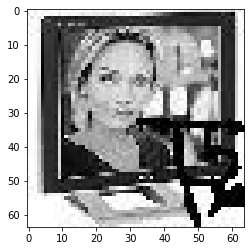

[[1.]]


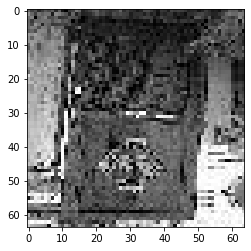

[[4.149732e-06]]


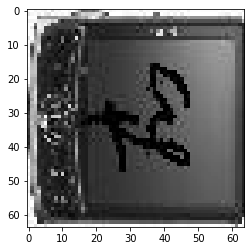

[[1.]]


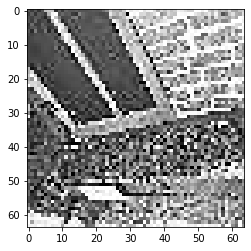

[[2.934884e-11]]


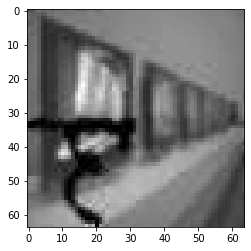

[[1.]]


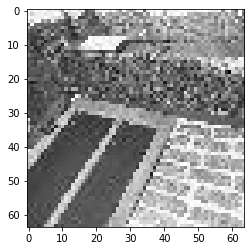

[[1.8790955e-06]]


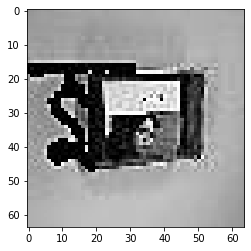

[[1.]]


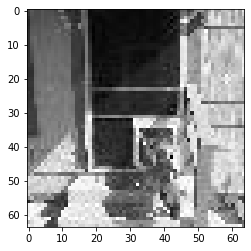

[[3.1274425e-10]]


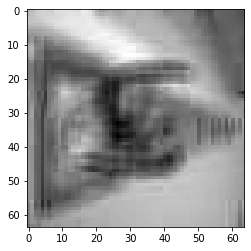

[[0.99810034]]


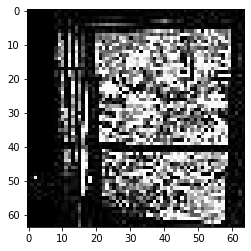

[[7.1018874e-13]]


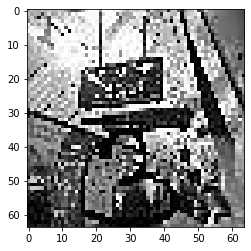

[[0.99999976]]


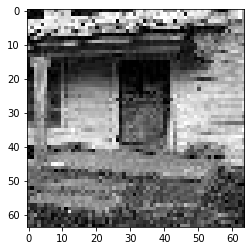

[[1.9391458e-05]]


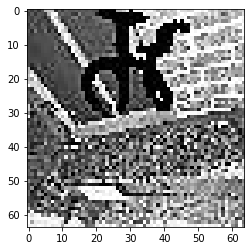

[[1.]]


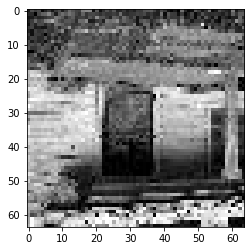

[[4.0778203e-09]]


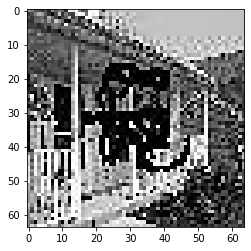

[[1.]]


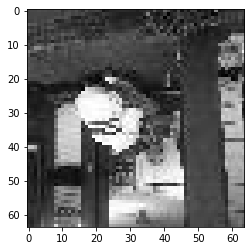

[[6.333402e-13]]


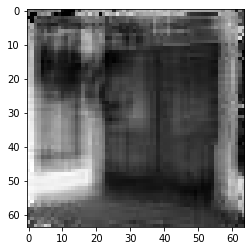

[[0.9898275]]


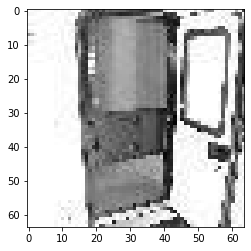

[[1.8194639e-10]]


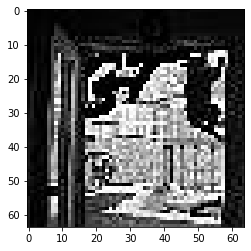

[[1.]]


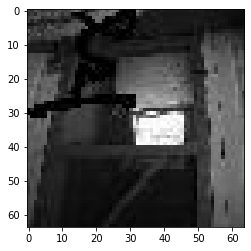

[[1.]]


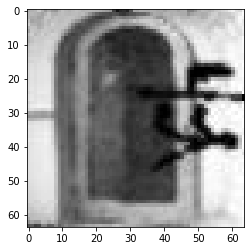

[[1.]]


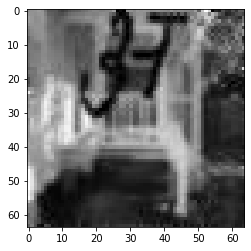

[[1.]]


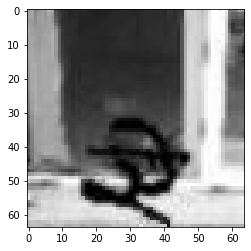

[[1.]]


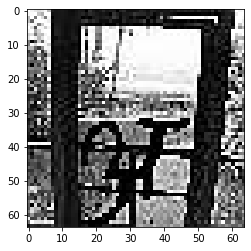

[[1.]]


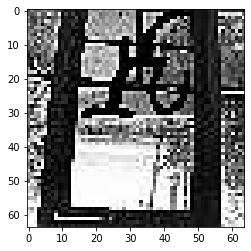

[[1.]]


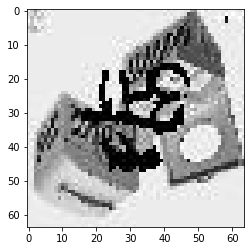

[[1.]]


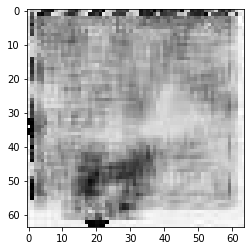

[[0.99927956]]


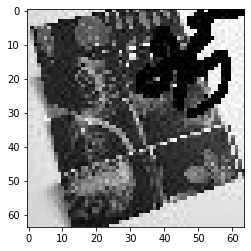

[[1.]]


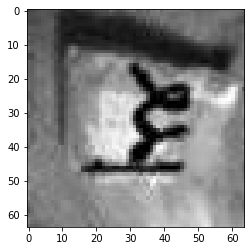

[[1.]]


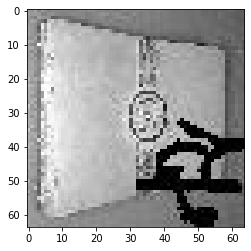

[[1.]]


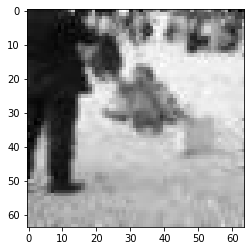

[[0.00013709]]


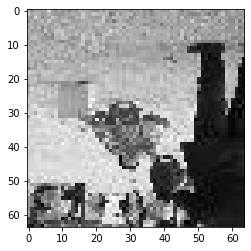

[[1.471466e-11]]


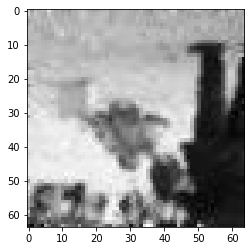

[[7.8044776e-10]]


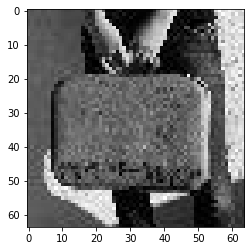

[[6.0275815e-09]]


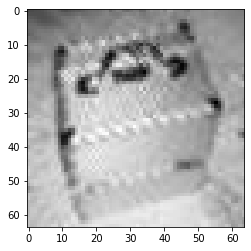

[[0.00016265]]


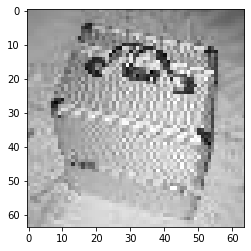

[[1.6296968e-05]]


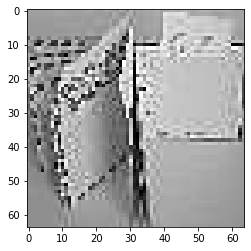

[[2.3090583e-05]]


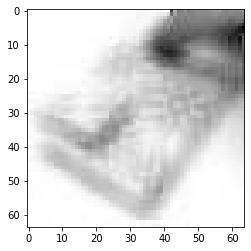

[[1.823616e-06]]


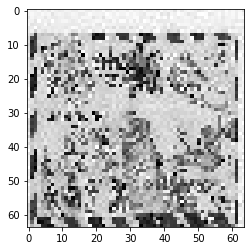

[[8.640863e-06]]


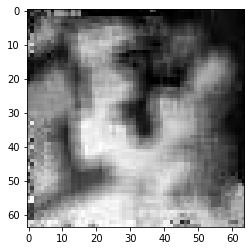

[[0.9986034]]


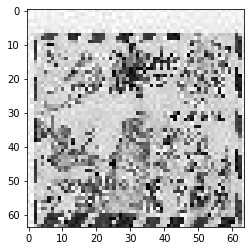

[[3.2561828e-05]]


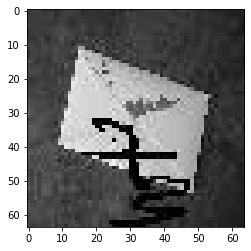

[[1.]]


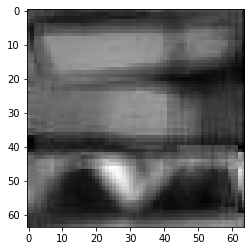

[[0.03829548]]


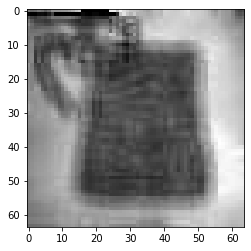

[[0.90010655]]


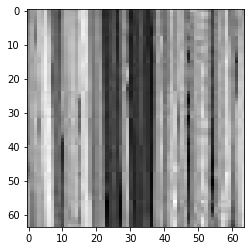

[[2.7645408e-05]]


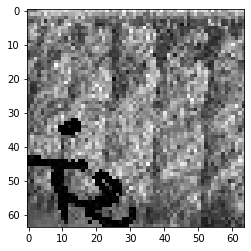

[[1.]]


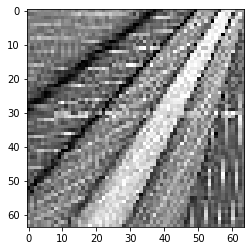

[[7.968226e-06]]


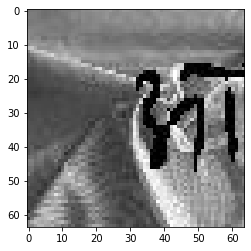

[[1.]]


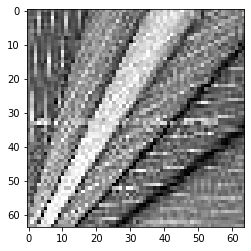

[[6.669604e-05]]


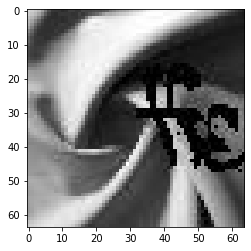

[[1.]]


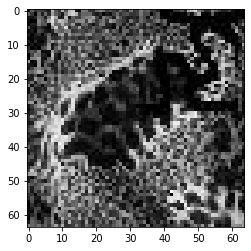

[[1.]]


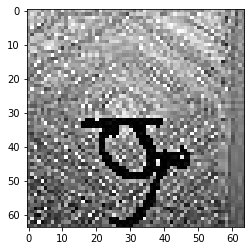

[[1.]]


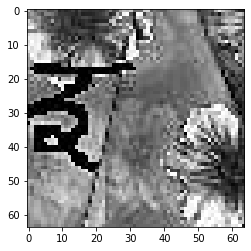

[[1.]]


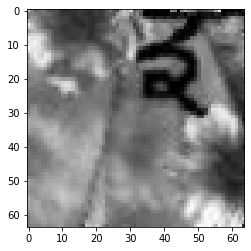

[[1.]]


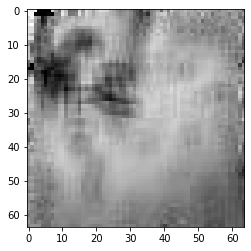

[[0.9999589]]


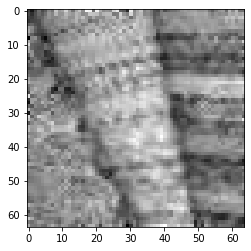

[[3.9042687e-05]]


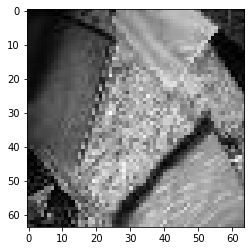

[[5.188482e-07]]


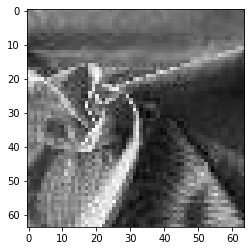

[[1.6549234e-07]]


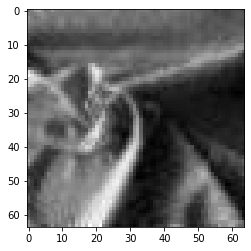

[[7.8113936e-07]]


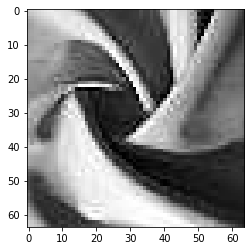

[[5.1276817e-14]]


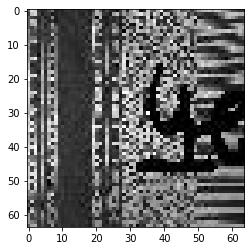

[[1.]]


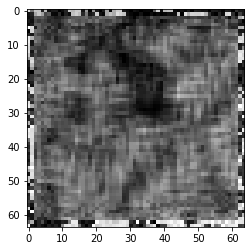

[[0.9982956]]


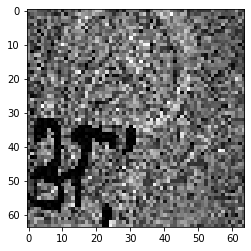

[[1.]]


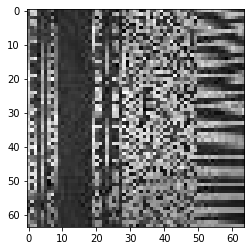

[[2.136717e-05]]


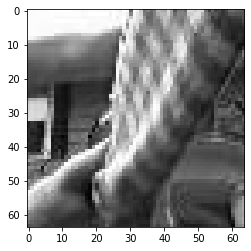

[[1.7531411e-07]]


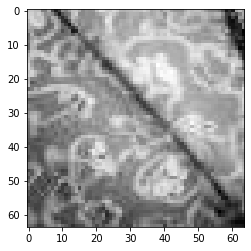

[[4.2080268e-05]]


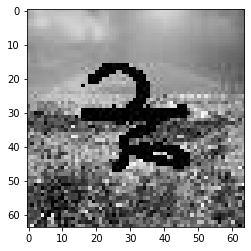

[[1.]]


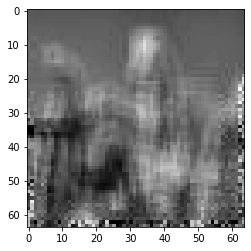

[[0.9988175]]


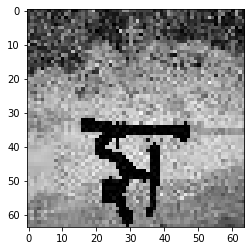

[[1.]]


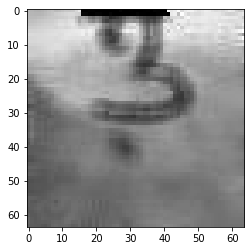

[[0.999982]]


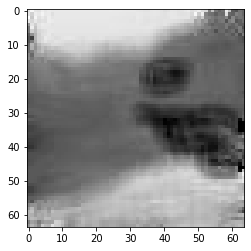

[[0.999959]]


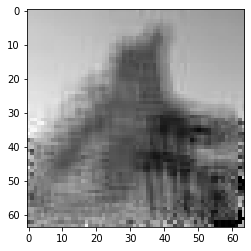

[[0.9998857]]


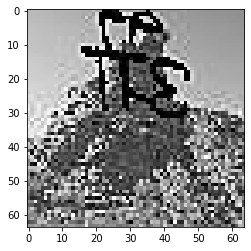

[[1.]]


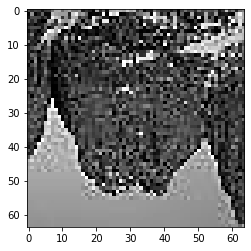

[[6.047287e-08]]


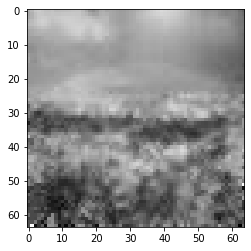

[[0.00031415]]


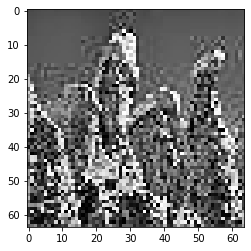

[[4.160852e-08]]


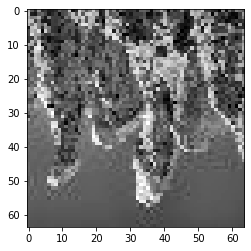

[[1.8073784e-05]]


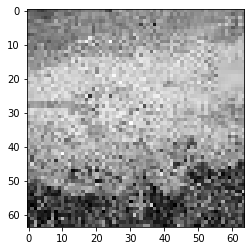

[[0.00021107]]


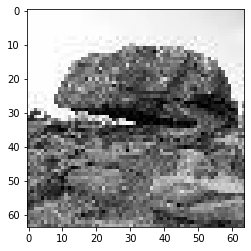

[[1.1877006e-09]]


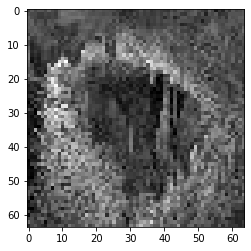

[[6.77561e-05]]


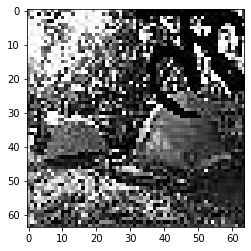

[[1.]]


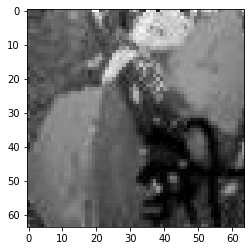

[[1.]]


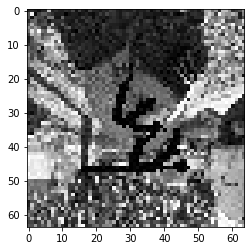

[[1.]]


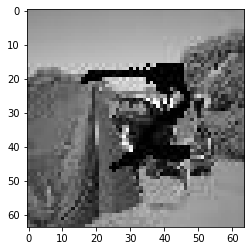

[[1.]]


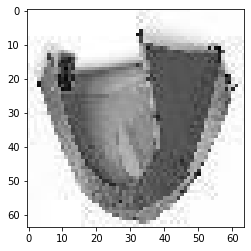

[[3.7214577e-06]]


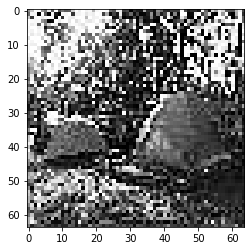

[[5.835286e-06]]


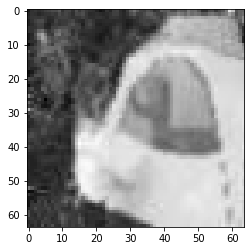

[[0.00014512]]


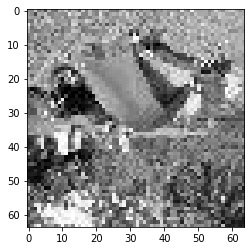

[[6.6410496e-07]]


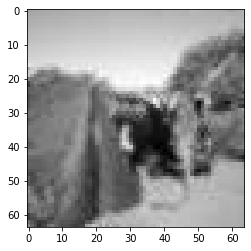

[[6.2653475e-05]]


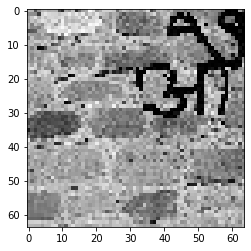

[[1.]]


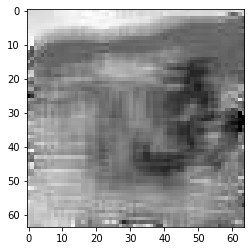

[[0.9997135]]


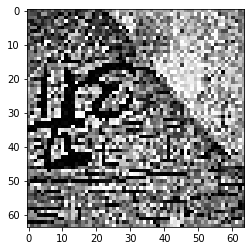

[[1.]]


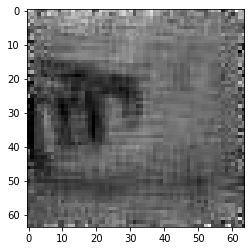

[[0.99972695]]


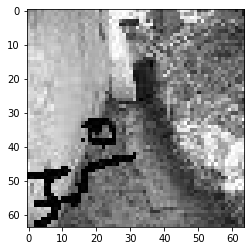

[[1.]]


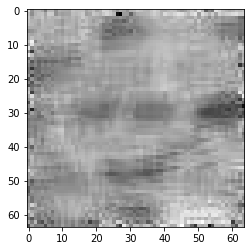

[[1.5155516e-05]]


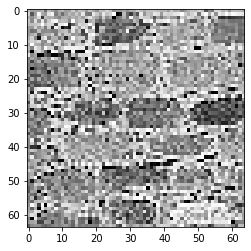

[[2.0107714e-06]]


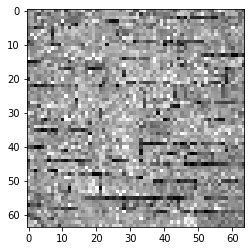

[[1.2478553e-05]]


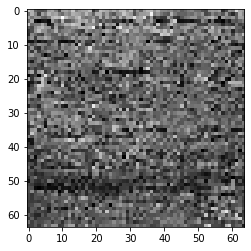

[[0.00035179]]


In [31]:

def display(img):
    plt.imshow(np.squeeze(img),cmap='gray')
    plt.show()
for img in x_test:
    display(img)
    x=cnn.predict(tf.expand_dims(img/255.0,axis=0))
    print(x)